This builds on TESQ-ml-ns-nogo-go

> **proposal 1**
> 
> Two class (e.g., CorrectStop vs. CorrectGo)
> 
> Leave-One-Out classifier...
> 
> Neural similarity of a subject to the group with a Stop vs. Go contrast might actually be indicative of performance.
> 
> subjects will naturally differ across the task as to how much their average signal responds to that, and the ones with better response might have better response inhibition.

We use the same neural data, but instead of regressing on classifying these classes, we take one class or the other or we combine them in some way and we regress on our self report variables.

So there are a couple of steps here...

1. iterate through subjects, holding out one at a time, and do the following steps.
2. Train a regressor across all the training subjects, regressing CorrectStop and CorrectGo on TESQ-E and other self report measures including FFQ either (a) independently (b) contrasted with each other (c) concatenated in a single image.
3. If a link can be established, we've shown there is a relevant link between TESQ-E or other self-report measure, and the neural signature.
4. ...that seems like a publication in itself!




As a first pass, we can simplify this a bit just trying that single classifier on all subjects. This means that we're using train for tes tset but it will give us an initial measure of feasibility.

We probably do need to restrict to a specific brain region though, and that means retraining. - I think that prefrontal cortex mask we have works well.

## Data already generated

Can we use data already generated in `SST_inhibition_cv.ipynb`?

In [1]:
import pickle
from IPython.core.display import display, HTML, Markdown

In [2]:
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [3]:
#results_filepath=ml_data_folderpath + "/SST/train_test_results_conditions_40subs_twoclasses.pkl"

In [4]:
#results_2c = pickle.load(open(results_filepath,'rb'))

In [5]:
from nilearn import plotting
from nilearn.masking import compute_brain_mask
import nltools as nlt

#plotting.view_img(results_2c[3]['CorrectGo'],threshold=0.0002)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [6]:
#plotting.plot_glass_brain(results_2c[3]['CorrectGo'])

In [7]:
#plotting.view_img(results_2c[3]['CorrectStop'],cmap='blue_red')

In [8]:
background_img = nlt.Brain_Data('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain.nii').to_nifti()

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


Not quite--we need a PFC mask I think. But we can use the script already written to do that.

## Setup

In [9]:
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath("../../ml/"))

from apply_loocv_and_save import *
from dev_wtp_io_utils import *
import gc
import nibabel as nib

from os import path



python initialized for apply_loocv_and_save
cpus available; cpus to use:
28 25
28


In [10]:
from analyze_results import *

## condition_contrast

In [11]:
#load the matrix associated with this file
sl_mat = scipy.io.loadmat(
'/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV073/SPM.mat',
simplify_cells=True            
)
mat_betas = sl_mat['SPM']['Vbeta']

In [12]:
[mat_betas[beta_i]['descrip'] for beta_i in range(len(mat_betas))]

['spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)',
 'spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)',
 'spm_spm:beta (0003) - Sn(1) FailedStop*bf(1)',
 'spm_spm:beta (0004) - Sn(1) Cue*bf(1)',
 'spm_spm:beta (0005) - Sn(1) R1',
 'spm_spm:beta (0006) - Sn(1) R2',
 'spm_spm:beta (0007) - Sn(1) R3',
 'spm_spm:beta (0008) - Sn(1) R4',
 'spm_spm:beta (0009) - Sn(1) R5',
 'spm_spm:beta (0010) - Sn(1) constant']

## stitching contrasts together in different ways

We'd want:

 - contrast of the two conditions
 - each of the two conditions alone.
 
The contrast is a little tricky. Easiest thing is to try each of the conditions alone. Stitching the two together might not be too hard. Let's try doing CorrectStop first, and then we'll try concatenating the images. Doing a contrast is actually the most difficult becuase I have to backtrack in the process to generate new betas (see https://docs.google.com/presentation/d/1K-nFrZYE6rR8t0myNyacB7frBzV3B1--nMqPhVkwL8E/edit#slide=id.geeff6890fb_0_16).

See `different ways of combining images.ipynb`.

## template

## regressing on self report

In [13]:
nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


dataset_name = 'conditions'

from nilearn.decoding import DecoderRegressor, Decoder

script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s

#get a PFC mask
#pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)

In [21]:
from outlier_detection import repeated_outlier_removal,outlier_detection_median_sd

def sr_regressor_trans_func(X):
#         print(X.columns)
#         print(X[self_report_regression_var])
    y = X[self_report_regression_var].copy()
    y_outliers_removed = repeated_outlier_removal(y,outlier_detection_median_sd,show_plot=True)
    
    return(y_outliers_removed)

def decoderConstructor(*args, **kwargs):
    return(DecoderRegressor(scoring='neg_mean_absolute_error',verbose=0, *args, **kwargs))



In [15]:
def do_complete_sr_regression_analysis_for_mask(
    self_report_regression_var,
    results_filepath,
    source_dataset_relpath,
    mask_filepath = None,
    mask_threshold = None,
):
    if mask_filepath is not None:
        mask_filename = os.path.basename(mask_filepath)
        mask_name = mask_filename.split(".")[0]

        display(Markdown("## " + mask_name))
        mask_img = create_mask_from_images([mask_filepath],threshold=mask_threshold)
    else:
        mask_img = None
    
    dataset_name = 'conditions'
    
    brain_data_filepath = ml_data_folderpath + source_dataset_relpath
    #brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'
    


    if path.exists(results_filepath) is False:
        apply_loocv_and_save(
            results_filepath = results_filepath,
            brain_data_filepath = brain_data_filepath,
            train_test_markers_filepath = train_test_markers_filepath,
#            subjs_to_use = 20,
            decoderConstructor = decoderConstructor,
            response_transform_func=sr_regressor_trans_func,
            mask=mask_img, clean=False,
        decoder_standardize=False
        )
    print(results_filepath)
    results=pickle.load(open(results_filepath,'rb'))


    visualize_series_corr(results[2]['y'],results[2]['y_pred'])

    return(results)


In [16]:
from analyze_results import *

In [17]:

data_by_ppt_name = "data_by_ppt_2021_12_29.csv"


individual_differences = pd.read_csv(ml_data_folderpath + "/"+ data_by_ppt_name)
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

", ".join(individual_differences.columns)

'subject, cancer_promoting_minus_preventing_FCI, cancer_promoting_minus_preventing_FFQ, cancer_promoting_minus_preventing_craved_FCI, cancer_promoting_minus_preventing_craved_FFQ, cancer_promoting_minus_preventing_liked_FCI, cancer_promoting_minus_preventing_liked_FFQ, cancer_promoting_FCI, cancer_promoting_FFQ, cancer_preventing_FCI, cancer_preventing_FFQ, BSCS, cSES, EDM, BIS_11, PCS, RS, TRSQ, bf_1, weight_0, height_0, birthsex, age365, bmi_0, bmi_1, bmi, bf_1_controlled, bf_1_bsexnormedzs, ACES_sum, ACES_household_dysfunction, ACES_neglectful_parenting, ACES_abuse, ACES_divorced_separated, BFI_agreeableness, BFI_conscientiousness, BFI_extraversion, BFI_neuroticism, BFI_openness, DEMO_mcarthur_social_standing, IMI_effort_importance, IMI_interest_enjoyment, IMI_perceived_choice, IMI_perceived_competence, IMI_value_usefulness, IPAQ_moderateminutes, IPAQ_sittinghours, IPAQ_vigorousminutes, IPAQ_walkingminutes, NCS_get_job_done, NCS_deliberating_issues, NCS_prefer_complex, NCS_prefer_li

In [18]:
harvox_folderpath = ml_data_folderpath + "/masks/response_inhibition_related/harvardoxford/"
neurosynth_folderpath = ml_data_folderpath + "/masks/response_inhibition_related/"



def get_mask_df(mask_folder,mask_threshold):
    mask_name_list = os.listdir(mask_folder)
    mask_dict_list = []
    for mask_filename in mask_name_list:
        mask_filepath = mask_folder + mask_filename
        if os.path.isdir(mask_filepath):
            continue # this is a directory, don't process it.
            
        mask_dict_list = mask_dict_list + [
            {'name':mask_filename.split(".")[0],
                'filename' : mask_filename,
             'filepath' : mask_filepath,
             'threshold': mask_threshold
            }]
    return(pd.DataFrame(mask_dict_list))

mask_list = pd.concat([get_mask_df(harvox_folderpath,30),
          get_mask_df(neurosynth_folderpath,0)])


/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_bf_1/correct_stop_w_supplementary/regress_sr_no_zscorebf_1_84subs_wholebrain.pkl
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_bf_1/correct_stop_w_supplementary/regress_sr_no_zscorebf_1_84subs_wholebrain.pkl


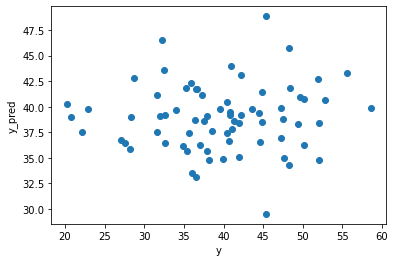

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_bf_1/correct_go_w_supplementary/regress_sr_no_zscorebf_1_84subs_wholebrain.pkl
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_bf_1/correct_go_w_supplementary/regress_sr_no_zscorebf_1_84subs_wholebrain.pkl


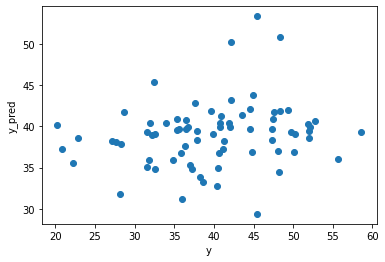

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_bf_1/correct_cond_spatially_concatenated/regress_sr_no_zscorebf_1_84subs_wholebrain.pkl
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_bf_1/correct_cond_spatially_concatenated/regress_sr_no_zscorebf_1_84subs_wholebrain.pkl


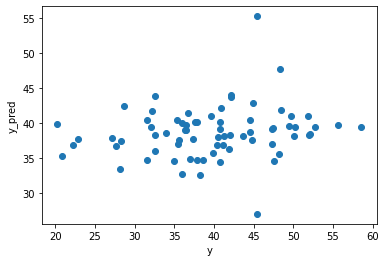

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_cancer_promoting_minus_preventing_FFQ/correct_stop_w_supplementary/regress_sr_no_zscorecancer_promoting_minus_preventing_FFQ_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 55 subjects overlapping between the subjects marked for train data and the training dump file itself.
cancer_promoting_minus_preventing_FFQ


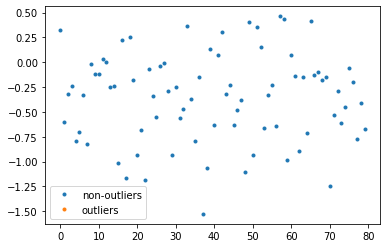

80 , 80
test_train_set: 9549
brain_data_filepath: 168
pkl_file: 168
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
80
81
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. predicting. test score was:. -0.15619216281930448
fold 2 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DE

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.19330600899950373
fold 3 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.07359468665160196
fold 4 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.4730740327471648
fold 5 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.2909106785880134
fold 6 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.34878391099888983
fold 7 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.30336439563028134
fold 8 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6131199219708328
fold 9 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7541932244237242
fold 10 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV089']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5767836789483359
fold 11 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.10222225650316791
fold 12 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.8292124105548395
fold 13 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5175961200872518
fold 14 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV034']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.38299817004844494
fold 15 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7015508154925882
fold 16 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.46676125944229474
fold 17 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6199804011369028
fold 18 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.0421498987223029
fold 19 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.9451939169605106
fold 20 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.20113759062984538
fold 21 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.15946260915321986
fold 22 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV177']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.2649587502754376
fold 23 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4262511812459008
fold 24 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.011920429838515767
fold 25 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.8941928069409955
fold 26 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.2603859464661579
fold 27 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7105261659875948
fold 28 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.165780559147751
fold 29 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.1865591741087441
fold 30 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.3769361416614265
fold 31 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.16449129381480587
fold 32 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.531567607755733
fold 33 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4105515308626983
fold 34 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.2924226640242599
fold 35 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.3634470988633254
fold 36 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV036']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.418275591399643
fold 37 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.013420670836463588
fold 38 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6738291312926472
fold 39 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.3198502238856755
fold 40 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.09875461316097522
fold 41 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.28496889837065276
fold 42 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6020986910977735
fold 43 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.0641096179830597
fold 44 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.1400600852268522
fold 45 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.09336257979981716
fold 46 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5517838859807253
fold 47 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.20257309336587764
fold 48 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.34996562969297124
fold 49 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.802845453611051
fold 50 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.11703677461149614
fold 51 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.337101908331553
fold 52 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.30749338225443884
fold 53 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.05158234454944455
fold 54 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.1322442121362586
fold 55 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.837209604126316
fold 56 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV023']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.07939917287801518
fold 57 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.473222063943171
fold 58 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5215928227178901
fold 59 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.8173500828757225
fold 60 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.36114997965638274
fold 61 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.00020279455333838126
fold 62 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7354014488056706
fold 63 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.8436993650306461
fold 64 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.30630989835888245
fold 65 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.06495475636109194
fold 66 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.24845092582203043
fold 67 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.061262860853533385
fold 68 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.29700914597214445
fold 69 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV030']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5245362907303976
fold 70 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.20509001583197975
fold 71 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.528606799501514
fold 72 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.8512998587979497
fold 73 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.36801856673330735
fold 74 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.33650658940163625
fold 75 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.13376226642827937
fold 76 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5628210554419656
fold 77 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7536508235826457
fold 78 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.25832261103504633
fold 79 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.19751376752797728
fold 80 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV016']. prepping fold data.... fitting.... 652.2 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.383745463370113
-0.15619216281930448
-0.15619216281930448
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_cancer_promoting_minus_preventing_FFQ/correct_stop_w_supplementary/regress_sr_no_zscorecancer_promoting_minus_preventing_FFQ_84subs_wholebrain.pkl


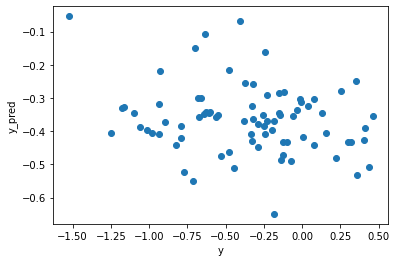

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_cancer_promoting_minus_preventing_FFQ/correct_go_w_supplementary/regress_sr_no_zscorecancer_promoting_minus_preventing_FFQ_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 58 subjects overlapping between the subjects marked for train data and the training dump file itself.
cancer_promoting_minus_preventing_FFQ


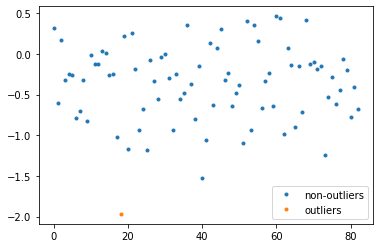

83 , 82
cancer_promoting_minus_preventing_FFQ


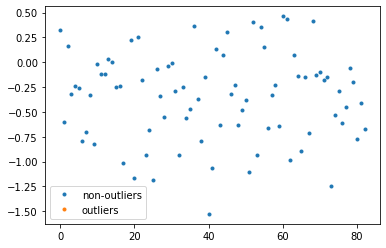

82 , 82
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 166
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
82
84
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. predicting. test score was:. -0.3618883791931271
fold 2 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.38168216704654423
fold 3 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.016025692594132945
fold 4 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.074808569477386
fold 5 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV012']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.026521370921908316
fold 6 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.21202692971367815
fold 7 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5083510136891389
fold 8 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4444793278768038
fold 9 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6398381012845127
fold 10 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.9837989492389803
fold 11 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV089']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.628868342307134
fold 12 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.0179242620846497
fold 13 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.9731145119748696
fold 14 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.35111221033576845
fold 15 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV034']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.2625576447474722
fold 16 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6534733008897823
fold 17 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.48611472437136893
fold 18 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5455108771530999
fold 19 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.08303967075517549
fold 20 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.1496174622342088
fold 21 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.20773140297993636
fold 22 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.22941624532931326
fold 23 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV177']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.11649875156282175
fold 24 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5139517952473036
fold 25 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.22393418575742563
fold 26 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6878820399698171
fold 27 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.40858617015854537
fold 28 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.3573665273104447
fold 29 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.16081887455872432
fold 30 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.28014564320795043
fold 31 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.36094796220872183
fold 32 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.31505049970036886
fold 33 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7439056829738604
fold 34 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.43356756440464256
fold 35 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.07399385330933461
fold 36 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4103425043527202
fold 37 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV036']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.24924987725535153
fold 38 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.02021553070726806
fold 39 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5298352451612752
fold 40 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.15569008981998422
fold 41 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.02063266790961432
fold 42 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.24137258231040504
fold 43 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7232094063460833
fold 44 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.03329068236087662
fold 45 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.094124376832043
fold 46 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.385124853806074
fold 47 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.27093045533838017
fold 48 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.28341481047411987
fold 49 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6031441748592379
fold 50 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2681592457132311
fold 51 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.13805118817329654
fold 52 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.3058308026011157
fold 53 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5741369494828841
fold 54 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.01720035883982085
fold 55 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.3120152578599157
fold 56 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6670347852562267
fold 57 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV023']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.176041635361127
fold 58 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5853676981632036
fold 59 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5520613921361308
fold 60 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.057691809275596
fold 61 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.0284139253350476
fold 62 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.15697839496985816
fold 63 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.9573676910630913
fold 64 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.8952855780784097
fold 65 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5623855637992236
fold 66 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.3808331324509967
fold 67 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.28120023585688964
fold 68 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.10563229677144043
fold 69 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV009']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5541672987892897
fold 70 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4429192582295045
fold 71 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV030']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4581275447002038
fold 72 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.1773124341857392
fold 73 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.22264052426150727
fold 74 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.9123748757971423
fold 75 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.2346633945476797
fold 76 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.227046050576579
fold 77 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.1820110045343618
fold 78 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.600601515187456
fold 79 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.633540994251902
fold 80 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.03679141113666318
fold 81 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.08052276835809302
fold 82 of 82
In order to test on a training group of 81 items, holding out the following subjects:['DEV016']. prepping fold data.... fitting.... 668.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4426689970236744
-0.3618883791931271
-0.3618883791931271
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_cancer_promoting_minus_preventing_FFQ/correct_go_w_supplementary/regress_sr_no_zscorecancer_promoting_minus_preventing_FFQ_84subs_wholebrain.pkl


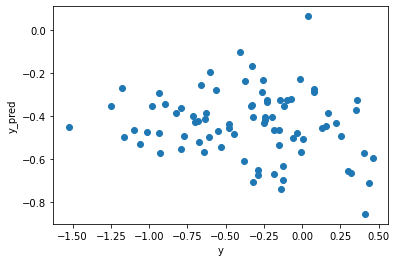

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_cancer_promoting_minus_preventing_FFQ/correct_cond_spatially_concatenated/regress_sr_no_zscorecancer_promoting_minus_preventing_FFQ_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 55 subjects overlapping between the subjects marked for train data and the training dump file itself.
cancer_promoting_minus_preventing_FFQ


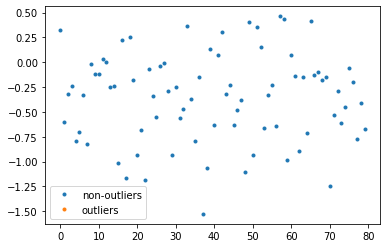

80 , 80
test_train_set: 9549
brain_data_filepath: 175
pkl_file: 168
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
80
81
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.21273833181250446
fold 2 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV053']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.27885889599047964
fold 3 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.08365861457739243
fold 4 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.251026710233692
fold 5 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.2706340782669097
fold 6 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.4977298435154365
fold 7 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.4064111657245371
fold 8 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.5658642297148244
fold 9 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.9570352874521405
fold 10 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV089']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.6145905768227103
fold 11 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.00892633005868837
fold 12 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.8992815329657492
fold 13 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.44493909889310396
fold 14 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV034']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.2940241322092751
fold 15 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.6185317492901204
fold 16 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.3594666523341722
fold 17 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.5438317220128697
fold 18 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.08109974436083112
fold 19 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.0829301647544136
fold 20 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.18218062789241918
fold 21 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.17967730151254846
fold 22 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV177']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.14379315195549192
fold 23 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.4646087212809546
fold 24 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.07171850585443329
fold 25 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.8530456988412249
fold 26 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.3625038144423177
fold 27 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.5390269191153834
fold 28 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.09988988879120339
fold 29 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.19061074516886448
fold 30 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.38817823013468844
fold 31 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.23872047508441274
fold 32 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.6591283263541545
fold 33 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.4537111075178838
fold 34 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.18057542926225278
fold 35 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.3843565106127005
fold 36 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV036']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.3109460578032798
fold 37 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.00015097856731183246
fold 38 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.6549879205740616
fold 39 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.28055967479093963
fold 40 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.04135742291446137
fold 41 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.35318635978240265
fold 42 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.7258066512976666
fold 43 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.07360205642074646
fold 44 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.10176928899778731
fold 45 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.1610102282168201
fold 46 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.4501881968464963
fold 47 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.17622569927855625
fold 48 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.42703733580478587
fold 49 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.004131934302822
fold 50 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.08567544162307777
fold 51 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.24555958338642042
fold 52 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.3755303037641611
fold 53 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.036662774600261794
fold 54 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.3070243412078151
fold 55 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.7497588328906712
fold 56 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV023']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.09197065312454106
fold 57 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.44567277476540956
fold 58 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.4916361974985132
fold 59 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.7872799845739212
fold 60 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.4354973875801271
fold 61 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.015332944516290914
fold 62 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.785702529237003
fold 63 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.8855351091229232
fold 64 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.48872473720774
fold 65 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.19940282149217226
fold 66 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.2614320562504948
fold 67 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.05119602019489655
fold 68 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.3340819939257682
fold 69 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV030']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.5669268689724408
fold 70 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.21588906592084497
fold 71 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.2134993958803229
fold 72 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.9184976853231503
fold 73 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.35961536636814395
fold 74 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.30407770980197946
fold 75 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.15569303274274116
fold 76 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.6079599213564659
fold 77 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.6736871045124382
fold 78 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.13003096759820754
fold 79 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.146522193836631
fold 80 of 80
In order to test on a training group of 79 items, holding out the following subjects:['DEV016']. prepping fold data.... fitting.... 1.3 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.5036041791040509
-0.21273833181250446
-0.21273833181250446
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_cancer_promoting_minus_preventing_FFQ/correct_cond_spatially_concatenated/regress_sr_no_zscorecancer_promoting_minus_preventing_FFQ_84subs_wholebrain.pkl


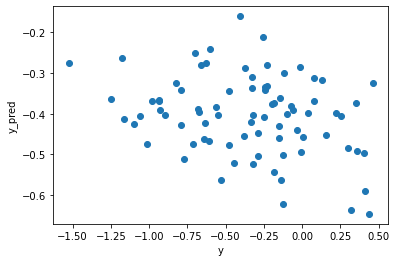

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/correct_stop_w_supplementary/regress_sr_no_zscoreTESQ_E_sum_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 55 subjects overlapping between the subjects marked for train data and the training dump file itself.
TESQ_E_sum


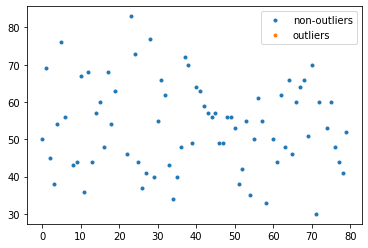

75 , 75
test_train_set: 9549
brain_data_filepath: 168
pkl_file: 168
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
75
81
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. predicting. test score was:. -23.511173188966602
fold 2 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.4509465301805733
fold 3 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -7.834867784254769
fold 4 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.033398095081402
fold 5 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -11.890010445395497
fold 6 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV053']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -7.886658799138225
fold 7 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.6658666633800365
fold 8 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -16.06531752482845
fold 9 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5445740351762254
fold 10 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.856811723761446
fold 11 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.235969297327209
fold 12 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -22.97218293716098
fold 13 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -17.580187461365583
fold 14 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -7.07120956832334
fold 15 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -9.621928725901768
fold 16 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -13.137845018093444
fold 17 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.2374694662925947
fold 18 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -26.488759890116242
fold 19 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.034379239175429
fold 20 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.758470426484294
fold 21 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.969120491015637
fold 22 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -14.355029991640755
fold 23 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -14.40031184051714
fold 24 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2861028145704267
fold 25 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV036']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -26.734199314602378
fold 26 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.6514917451594187
fold 27 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -16.7801045415801
fold 28 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.268208741821553
fold 29 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.023350206544734
fold 30 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -17.521794939330263
fold 31 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -8.2485978348398
fold 32 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -10.737196979158973
fold 33 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.4772948500361736
fold 34 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.0302554696932873
fold 35 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.415555371745455
fold 36 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.318427239570539
fold 37 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -9.398677310406725
fold 38 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.732320845014122
fold 39 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.950235644084493
fold 40 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -19.164951081451925
fold 41 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.0417091154125444
fold 42 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.9028720565481265
fold 43 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -17.822124533841745
fold 44 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.224771274562613
fold 45 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -8.150506924226455
fold 46 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -11.654727807876569
fold 47 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -11.086665259941647
fold 48 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.3520962891816097
fold 49 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.002397897965025
fold 50 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -10.840928986896031
fold 51 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.639847478753168
fold 52 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.0662293697425511
fold 53 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -13.599323292301648
fold 54 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -17.709164086870032
fold 55 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -20.589978204822096
fold 56 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -7.954126653131119
fold 57 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -27.29428533865569
fold 58 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -14.111568740935319
fold 59 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.589626876888026
fold 60 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.2846980528223071
fold 61 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -11.435989686706975
fold 62 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.282078652370117
fold 63 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -7.759080534693865
fold 64 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.773082306122284
fold 65 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.949554545221574
fold 66 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -11.556502961776381
fold 67 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -24.951754270740153
fold 68 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -14.635975196551499
fold 69 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -17.260449734682652
fold 70 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.822789834781247
fold 71 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -15.503082208341603
fold 72 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.8405434199444457
fold 73 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -27.46275017667817
fold 74 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.31628579791046
fold 75 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -15.005352573978605
-23.511173188966602
-23.511173188966602
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/correct_stop_w_supplementary/regress_sr_no_zscoreTESQ_E_sum_84subs_wholebrain.pkl


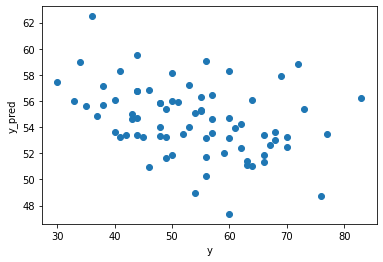

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/correct_go_w_supplementary/regress_sr_no_zscoreTESQ_E_sum_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 58 subjects overlapping between the subjects marked for train data and the training dump file itself.
TESQ_E_sum


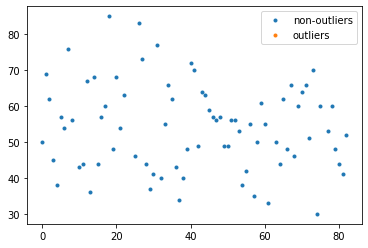

78 , 78
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 166
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
78
84
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. predicting. test score was:. -17.26790392424695
fold 2 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV0

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.014449599075405
fold 3 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -16.621075295601678
fold 4 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -18.43704240574244
fold 5 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV012']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.2874828472181434
fold 6 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -16.01937002552853
fold 7 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -9.049509849657497
fold 8 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -15.903314937446552
fold 9 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.5729083377155746
fold 10 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -8.655748842893395
fold 11 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -15.961252803824578
fold 12 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.41677226565761316
fold 13 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5123908494774412
fold 14 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -7.0577606669888695
fold 15 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -11.920132440273512
fold 16 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.374139524420414
fold 17 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.2103854585853
fold 18 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -22.83209278109063
fold 19 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.973380265372775
fold 20 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.325172205041682
fold 21 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -10.00203500418629
fold 22 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -10.284500602309386
fold 23 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.380082559080549
fold 24 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -19.520893854948923
fold 25 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV025']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -30.106568710664398
fold 26 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -7.864940677983213
fold 27 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -14.1231900329866
fold 28 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.938695109728755
fold 29 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -10.832673197543933
fold 30 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -20.062198680525356
fold 31 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.193485940515707
fold 32 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -17.513266720825392
fold 33 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.4029005203161944
fold 34 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.8916538564180101
fold 35 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV036']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -22.673330647908564
fold 36 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5149764317074812
fold 37 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -18.164682328538944
fold 38 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -9.961947748272081
fold 39 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -10.122409095346299
fold 40 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.448031432779118
fold 41 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -17.5647106523437
fold 42 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.06606331625484074
fold 43 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.8173998252178905
fold 44 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -9.13122666405797
fold 45 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -17.99417095519491
fold 46 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.101626002987835
fold 47 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -20.780059076378535
fold 48 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -18.793630554489283
fold 49 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -28.271856741362747
fold 50 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -9.229192021408977
fold 51 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.4745519800346827
fold 52 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -27.331403284160494
fold 53 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -8.177562778256991
fold 54 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.046572210027584
fold 55 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV023']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.0924030953590389
fold 56 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.000449310003141
fold 57 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -11.964479710931926
fold 58 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -10.128906236700729
fold 59 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -34.32794514255096
fold 60 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.142550343957048
fold 61 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.998053692614313
fold 62 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -16.232455458199347
fold 63 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.43986626358003
fold 64 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -7.595072235723961
fold 65 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -16.649179473583928
fold 66 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.1154222495122212
fold 67 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV009']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.671008986558235
fold 68 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.276897557092198
fold 69 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.921942949498394
fold 70 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -7.680645710800164
fold 71 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -9.279019587506724
fold 72 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.2006120098775384
fold 73 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.862666689620077
fold 74 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9434210024645964
fold 75 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -12.253027237235983
fold 76 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.374520326145962
fold 77 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.484849369082482
fold 78 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -18.32865320150357
-17.26790392424695
-17.26790392424695
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/correct_go_w_supplementary/regress_sr_no_zscoreTESQ_E_sum_84subs_wholebrain.pkl


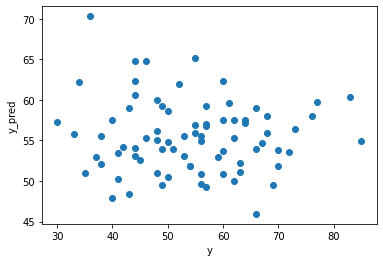

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/correct_cond_spatially_concatenated/regress_sr_no_zscoreTESQ_E_sum_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 55 subjects overlapping between the subjects marked for train data and the training dump file itself.
TESQ_E_sum


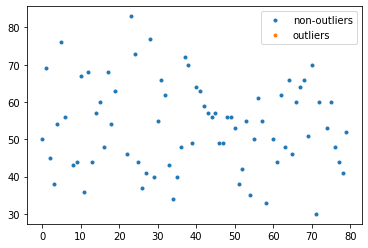

75 , 75
test_train_set: 9549
brain_data_filepath: 175
pkl_file: 168
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
75
81
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -19.203091997501367
fold 2 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV023']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.9032949544696436
fold 3 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -8.358348682785234
fold 4 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.566471852201154
fold 5 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -16.754089740029812
fold 6 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV053']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -4.832290625555245
fold 7 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.283227196690902
fold 8 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -15.534553347981067
fold 9 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.7407923430394732
fold 10 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -6.837214521913658
fold 11 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.6180945219776532
fold 12 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -22.69772732714212
fold 13 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -14.54105810608604
fold 14 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -4.935823329720847
fold 15 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -12.500395085238054
fold 16 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -19.076051095256986
fold 17 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -7.528959876207942
fold 18 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -26.87174047604745
fold 19 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.5323562546726208
fold 20 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.323189333413964
fold 21 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -7.746988758625626
fold 22 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -14.164984829957163
fold 23 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -14.051246479790805
fold 24 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.2180809476294527
fold 25 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV036']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -26.74730144221696
fold 26 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.11009138776518768
fold 27 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -16.8550265197334
fold 28 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -13.450134559488845
fold 29 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -12.035731651333172
fold 30 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -17.373672583425062
fold 31 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -5.720179840075559
fold 32 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -12.990796933345962
fold 33 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -7.089129214658726
fold 34 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -4.824945585016813
fold 35 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -7.088705747723566
fold 36 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -7.698686258963519
fold 37 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -10.618187838363824
fold 38 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -11.687577574318013
fold 39 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -11.1793981015999
fold 40 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -16.694089984790544
fold 41 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.5032570025755376
fold 42 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.8796093658751687
fold 43 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -15.660969646139144
fold 44 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.724749898307536
fold 45 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -7.397998414927777
fold 46 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -9.859795169910562
fold 47 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -13.340968944139199
fold 48 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -7.562633237200004
fold 49 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.1454739384013948
fold 50 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -7.720685738162317
fold 51 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -13.1486269096931
fold 52 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.460635219506095
fold 53 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -5.440889795475336
fold 54 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -14.937158528714953
fold 55 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -17.718206683588548
fold 56 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -8.5097385975293
fold 57 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -20.30019546292072
fold 58 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -11.327125292721568
fold 59 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -10.693151289088469
fold 60 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.2761786604997383
fold 61 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -12.968071689479174
fold 62 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -6.188680745868723
fold 63 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -6.450120715400253
fold 64 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -17.325346382872148
fold 65 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -10.089495071430086
fold 66 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -12.853993424175421
fold 67 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -25.91011289971261
fold 68 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -17.5068229718849
fold 69 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -9.900558195827799
fold 70 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.633651199671803
fold 71 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -16.793882961641337
fold 72 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -4.737938332607769
fold 73 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -26.97767004210131
fold 74 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -7.622032703628946
fold 75 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -14.694511219973137
-19.203091997501367
-19.203091997501367
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/correct_cond_spatially_concatenated/regress_sr_no_zscoreTESQ_E_sum_84subs_wholebrain.pkl


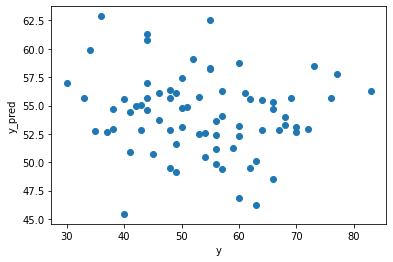

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_distraction/correct_stop_w_supplementary/regress_sr_no_zscoreTESQ_E_distraction_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 55 subjects overlapping between the subjects marked for train data and the training dump file itself.
TESQ_E_distraction


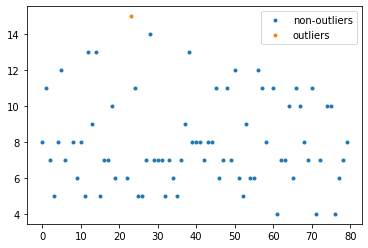

75 , 74
TESQ_E_distraction


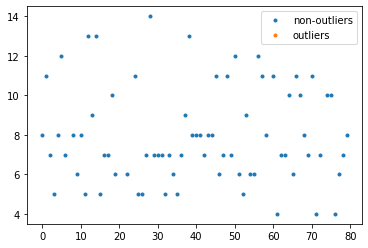

74 , 74
test_train_set: 9549
brain_data_filepath: 168
pkl_file: 168
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
74
81
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. predicting. test score was:. -6.120477882435434
fold 2 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV0

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.101204522518779
fold 3 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.5307549804045575
fold 4 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.380431294693369
fold 5 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.048961626319999
fold 6 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV053']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9780124368435725
fold 7 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.7029782592535385
fold 8 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.7768779727289363
fold 9 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.30621693931066574
fold 10 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.260996635618276
fold 11 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.17521612824557664
fold 12 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.07704504503826293
fold 13 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.3290404218562095
fold 14 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.042518449645565
fold 15 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.0688387965131145
fold 16 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.0740615788699648
fold 17 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.619942494101865
fold 18 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.394146363127451
fold 19 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.659828481757426
fold 20 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.728617005886381
fold 21 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6338136278685305
fold 22 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.2587039722763045
fold 23 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.976563187020314
fold 24 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6794447646129242
fold 25 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.126107201658966
fold 26 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.6110310603476687
fold 27 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.36076326705348283
fold 28 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.463621218618961
fold 29 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.715240222203924
fold 30 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.4658484330032095
fold 31 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.7470127999161864
fold 32 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7935850018465684
fold 33 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.8029407944679772
fold 34 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6827172348838815
fold 35 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.4434863939131297
fold 36 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.968424564724808
fold 37 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.332274911121571
fold 38 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5503281749977962
fold 39 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.4200995107720438
fold 40 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.030296073992579
fold 41 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.859889452449198
fold 42 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.335554992186154
fold 43 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.9896304823245714
fold 44 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.26054735627998227
fold 45 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.0081102234908492
fold 46 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.0296871401234213
fold 47 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.8821434283805782
fold 48 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.4764528831587995
fold 49 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2197804184113226
fold 50 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.18036970057078872
fold 51 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.3038174047200872
fold 52 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.3561653019248485
fold 53 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.6649801023986344
fold 54 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.265169102857957
fold 55 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9354269339199153
fold 56 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.2966669935021
fold 57 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4904099004601168
fold 58 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4963143567376065
fold 59 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.8924930492065695
fold 60 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.7445335255192003
fold 61 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.9791149942670607
fold 62 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.699271996860105
fold 63 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.445305385341575
fold 64 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.893710731245779
fold 65 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.11211138515818231
fold 66 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.8595966684352954
fold 67 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.488703621926052
fold 68 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.007875605404685
fold 69 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.0122741790141578
fold 70 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.726018219335936
fold 71 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.104456284735421
fold 72 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.059343920716424
fold 73 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.7414672651176701
fold 74 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 602.6 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.9010354203708051
-6.120477882435434
-6.120477882435434
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_distraction/correct_stop_w_supplementary/regress_sr_no_zscoreTESQ_E_distraction_84subs_wholebrain.pkl


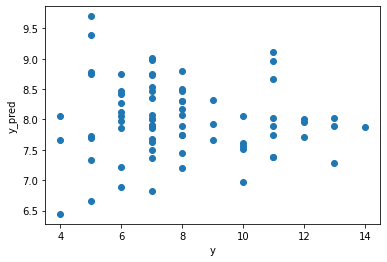

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_distraction/correct_go_w_supplementary/regress_sr_no_zscoreTESQ_E_distraction_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 58 subjects overlapping between the subjects marked for train data and the training dump file itself.
TESQ_E_distraction


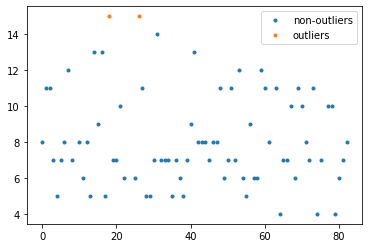

78 , 76
TESQ_E_distraction


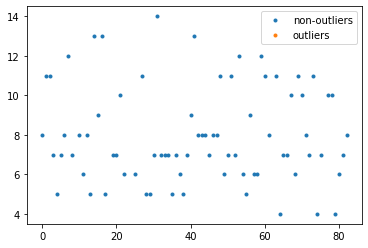

76 , 76
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 166
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
76
84
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. predicting. test score was:. -6.479838274847342
fold 2 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV0

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.817724243707847
fold 3 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2527819189051357
fold 4 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.12396298887732
fold 5 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.5013813906775777
fold 6 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV053']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.7545492570753325
fold 7 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.816031687722944
fold 8 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.094571372092522
fold 9 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.20202177630902796
fold 10 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.476729477448176
fold 11 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7154943226827228
fold 12 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.33994630521808133
fold 13 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.3709564521023925
fold 14 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.6409177756505198
fold 15 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7404084587635671
fold 16 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.1566226708406964
fold 17 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.3276369068190998
fold 18 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.526394014749691
fold 19 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.8118391254842967
fold 20 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.8602880937482684
fold 21 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5031544820569387
fold 22 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.10699815125281376
fold 23 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.394125749323427
fold 24 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.31910879610551035
fold 25 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.6806319908618272
fold 26 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.9506819730989164
fold 27 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV012']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.1878361063875396
fold 28 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2832731210087633
fold 29 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.12473248656317182
fold 30 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.082428708256085
fold 31 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7611969337094591
fold 32 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.1651075600449428
fold 33 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2437265294502602
fold 34 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.1296436698092318
fold 35 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.5040702804947355
fold 36 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV009']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.6098900319186855
fold 37 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.241416008593607
fold 38 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.094458183720823
fold 39 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.704604824906891
fold 40 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.13412847156100227
fold 41 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.5456317038046166
fold 42 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.8328568929252356
fold 43 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.349014245492162
fold 44 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.96822509948354
fold 45 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.912638462048255
fold 46 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.13209009967291152
fold 47 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9594162356334621
fold 48 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.1714816512297794
fold 49 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.6615471038959333
fold 50 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.1313776832575435
fold 51 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9445872551034586
fold 52 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4786040469841044
fold 53 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.270241040389017
fold 54 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.3537765797014494
fold 55 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.647381246518414
fold 56 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.105894121213641
fold 57 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.4251780088456414
fold 58 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.4541608987978787
fold 59 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6450393685385647
fold 60 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.3068662430015845
fold 61 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.0341115582309524
fold 62 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.911458398102585
fold 63 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.6955670790337516
fold 64 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.12986258623256
fold 65 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.340948057910211
fold 66 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.1609591879461316
fold 67 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.25625835614113424
fold 68 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9635706842767737
fold 69 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.87345274935379
fold 70 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.11233595280560316
fold 71 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5172784456742177
fold 72 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.613869639843461
fold 73 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.9677909434008978
fold 74 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.157344731987269
fold 75 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.8708794374822117
fold 76 of 76
In order to test on a training group of 75 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 619.1 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.197564071578988
-6.479838274847342
-6.479838274847342
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_distraction/correct_go_w_supplementary/regress_sr_no_zscoreTESQ_E_distraction_84subs_wholebrain.pkl


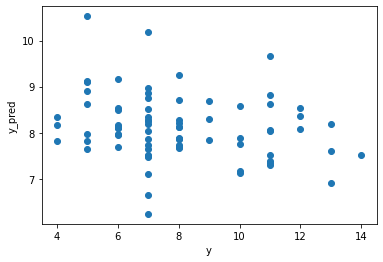

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_distraction/correct_cond_spatially_concatenated/regress_sr_no_zscoreTESQ_E_distraction_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 55 subjects overlapping between the subjects marked for train data and the training dump file itself.
TESQ_E_distraction


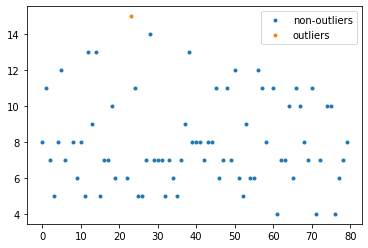

75 , 74
TESQ_E_distraction


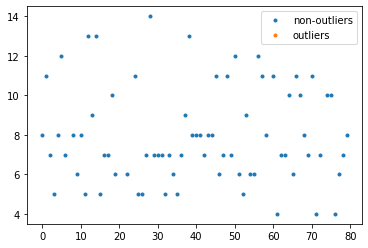

74 , 74
test_train_set: 9549
brain_data_filepath: 175
pkl_file: 168
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
74
81
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -5.754330715872589
fold 2 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV023']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -5.170790371347099
fold 3 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.3048966452521178
fold 4 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.1793416336329825
fold 5 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.9660598894738452
fold 6 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV053']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.4986230188185345
fold 7 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.87295308162377
fold 8 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.5641828607257775
fold 9 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.7338799177881103
fold 10 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.3806890085472174
fold 11 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.060199085343842995
fold 12 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.9540482767662635
fold 13 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.2018660399630487
fold 14 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.614340566282369
fold 15 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.8817414273986088
fold 16 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.3727212764889156
fold 17 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.6287291857955868
fold 18 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -5.584459531967335
fold 19 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.3983482747127347
fold 20 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.521839572929226
fold 21 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.07355965387996033
fold 22 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.31431478388294476
fold 23 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -5.204789222485712
fold 24 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.5038986954608102
fold 25 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.319886368555495
fold 26 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.243580279746797
fold 27 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.7754214069603629
fold 28 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.028794956759458756
fold 29 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -6.011225055344303
fold 30 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.19168749844409483
fold 31 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.100584726131965
fold 32 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.7414236741438387
fold 33 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.28053756775074135
fold 34 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.0479879251070177
fold 35 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.2944397592695047
fold 36 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.9622429474600773
fold 37 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.860361666548517
fold 38 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.0254368763022379
fold 39 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.439243315955302
fold 40 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.217266173363697
fold 41 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.0826029441190315
fold 42 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.669056739807427
fold 43 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.9902878735132
fold 44 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.1746963021362795
fold 45 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.0663470237824395
fold 46 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.5969723717021402
fold 47 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.8264759865845077
fold 48 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.9133472817561001
fold 49 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.1399944676314382
fold 50 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.19925691619929609
fold 51 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.40096920571176753
fold 52 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.5597296924398734
fold 53 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.5736686069640538
fold 54 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.9045643187449093
fold 55 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.4735628739578566
fold 56 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.6474592582210814
fold 57 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.8203613751421619
fold 58 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.012480187532605491
fold 59 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.1847436457375338
fold 60 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -4.280612772519605
fold 61 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.7916050394843017
fold 62 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -4.229123376278363
fold 63 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.679077645938664
fold 64 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.021680701105602
fold 65 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.001513625481450731
fold 66 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.3682826428375563
fold 67 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.2188764067362214
fold 68 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.02179274455771374
fold 69 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.410383925406113
fold 70 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.9196244894919614
fold 71 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.696017532983973
fold 72 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.8683232974170334
fold 73 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.1146550369919783
fold 74 of 74
In order to test on a training group of 73 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.9131362354827663
-5.754330715872589
-5.754330715872589
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_distraction/correct_cond_spatially_concatenated/regress_sr_no_zscoreTESQ_E_distraction_84subs_wholebrain.pkl


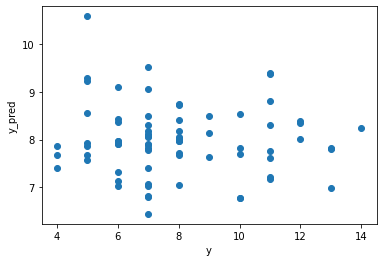

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_suppression/correct_stop_w_supplementary/regress_sr_no_zscoreTESQ_E_suppression_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 55 subjects overlapping between the subjects marked for train data and the training dump file itself.
TESQ_E_suppression


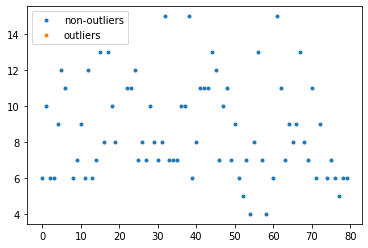

75 , 75
test_train_set: 9549
brain_data_filepath: 168
pkl_file: 168
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
75
81
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. predicting. test score was:. -1.0926811361975624
fold 2 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.668223499617488
fold 3 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.038465768704178
fold 4 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.534061708801559
fold 5 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4568901117826778
fold 6 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV053']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.1050752982264882
fold 7 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.578609660607997
fold 8 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.4744842415687227
fold 9 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9309425213931597
fold 10 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.11217392201578491
fold 11 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.7425996062743785
fold 12 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.37024415079512
fold 13 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.2690432586751967
fold 14 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.524106276045879
fold 15 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.639614740412833
fold 16 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5379187378767654
fold 17 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.698271246014702
fold 18 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.536620309169379
fold 19 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9239273938680785
fold 20 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.603671655215553
fold 21 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.599249287936857
fold 22 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4724329293696812
fold 23 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.810688951817891
fold 24 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2009714679027397
fold 25 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV036']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.637342200032057
fold 26 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.0116653649400469
fold 27 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.3828781374476797
fold 28 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.0944352818043317
fold 29 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.6094200498101667
fold 30 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.4551773915111035
fold 31 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.0903338315623117
fold 32 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.183101360712902
fold 33 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.153411999183513
fold 34 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.556770133000169
fold 35 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.502751509750576
fold 36 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.1898290201343613
fold 37 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.242742109449969
fold 38 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.4566721136516545
fold 39 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5886940124913664
fold 40 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.009073648111759
fold 41 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.2487228824686625
fold 42 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.7136765655295143
fold 43 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6952046539727021
fold 44 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4407368013379429
fold 45 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.908775567434901
fold 46 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2197979250373745
fold 47 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7042767812614716
fold 48 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.7860857239201398
fold 49 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6484352404622289
fold 50 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.1972953879238286
fold 51 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.7978613297838102
fold 52 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.793764703854837
fold 53 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.23028139455243135
fold 54 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.8886311948482515
fold 55 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.928667558787258
fold 56 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.337415292744934
fold 57 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.458735013316599
fold 58 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.0006183313375008
fold 59 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.48522422242083785
fold 60 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.0551011315636174
fold 61 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.6137972826623272
fold 62 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.2088785972468887
fold 63 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.371251301650021
fold 64 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.140574111899516
fold 65 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2468088268931439
fold 66 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.5429948113583034
fold 67 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.872090299076339
fold 68 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.3862777499440488
fold 69 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.734602673583346
fold 70 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9663929555477377
fold 71 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.7670596217838224
fold 72 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.7958705381135003
fold 73 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.037562324403144
fold 74 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.5359329338777972
fold 75 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 610.9 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.6335946089997595
-1.0926811361975624
-1.0926811361975624
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_suppression/correct_stop_w_supplementary/regress_sr_no_zscoreTESQ_E_suppression_84subs_wholebrain.pkl


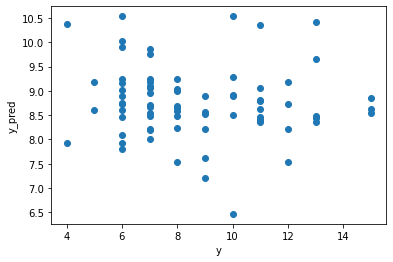

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_suppression/correct_go_w_supplementary/regress_sr_no_zscoreTESQ_E_suppression_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 58 subjects overlapping between the subjects marked for train data and the training dump file itself.
TESQ_E_suppression


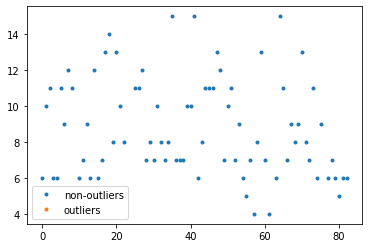

78 , 78
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 166
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
78
84
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. predicting. test score was:. -0.33158773746372106
fold 2 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DE

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.259979277928986
fold 3 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.576926155043145
fold 4 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.7609294127152193
fold 5 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV012']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9256665699139557
fold 6 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.484684108362179
fold 7 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2378566918313219
fold 8 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2124551240353707
fold 9 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.08925059138585922
fold 10 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.3266820272481237
fold 11 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.306111682477814
fold 12 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.5831626704435617
fold 13 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9678737673484683
fold 14 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.619146425523887
fold 15 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.2489961895605699
fold 16 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.430083647064574
fold 17 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.957262950382722
fold 18 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.6016337236297105
fold 19 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.688773753247977
fold 20 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5470348090491033
fold 21 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9603664110194519
fold 22 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.6651915181785544
fold 23 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.0904002319855728
fold 24 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5946143568877087
fold 25 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV025']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.3707894624004435
fold 26 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.482550699767593
fold 27 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.4200723745137687
fold 28 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.6988459178296758
fold 29 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.9849058754680016
fold 30 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9126902643930341
fold 31 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.8188404766313155
fold 32 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9427638733536572
fold 33 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.284975771421406
fold 34 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.547675389149914
fold 35 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV036']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.832723144059555
fold 36 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2389410817043682
fold 37 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.591620948300028
fold 38 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.3968386394192542
fold 39 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.48687312623348
fold 40 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.146521221583642
fold 41 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.912103971950714
fold 42 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.0391716651317324
fold 43 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.1653571441156725
fold 44 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.4336889063621392
fold 45 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.172854391313013
fold 46 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.4959157926084234
fold 47 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.689991779176305
fold 48 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.8372151264070489
fold 49 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.7276551467074945
fold 50 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.0427684962969526
fold 51 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.776370007901388
fold 52 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.0587663875076245
fold 53 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.803745067623428
fold 54 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.755445953608371
fold 55 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV023']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.00161193848132
fold 56 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.8100580123827212
fold 57 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.5931811508897926
fold 58 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.786095838842753
fold 59 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -6.864242061769534
fold 60 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.4756762235556273
fold 61 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.1155427402236757
fold 62 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.061762858062359
fold 63 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.2529521027608475
fold 64 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.1572075012474894
fold 65 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.707064394293111
fold 66 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.891659714297652
fold 67 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV009']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.43240400893853
fold 68 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9639181181696657
fold 69 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.057842395754532
fold 70 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.2930679348267624
fold 71 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -1.9413278561698952
fold 72 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -0.5836475272387212
fold 73 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -3.7830713866594756
fold 74 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.0687771434195934
fold 75 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -4.306077803756107
fold 76 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.0093967301433295
fold 77 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -5.723095133240095
fold 78 of 78
In order to test on a training group of 77 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 635.7 MiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. -2.6699054438459218
-0.33158773746372106
-0.33158773746372106
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_suppression/correct_go_w_supplementary/regress_sr_no_zscoreTESQ_E_suppression_84subs_wholebrain.pkl


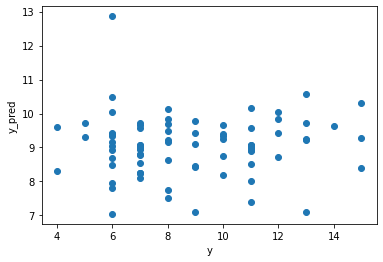

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_suppression/correct_cond_spatially_concatenated/regress_sr_no_zscoreTESQ_E_suppression_84subs_wholebrain.pkl
checked for intersection and no intersection between the brain data and the subjects was found.
there were 55 subjects overlapping between the subjects marked for train data and the training dump file itself.
TESQ_E_suppression


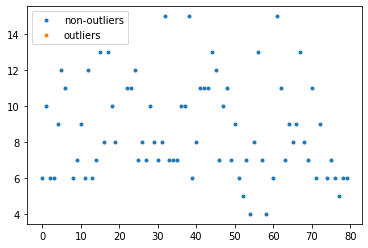

75 , 75
test_train_set: 9549
brain_data_filepath: 175
pkl_file: 168
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 24
subjs_to_use: 16
75
81
starting LeaveOneOut
new decoder parameters:
{'cv': GroupKFold(n_splits=3), 'estimator': 'svr', 'high_pass': None, 'low_pass': None, 'mask': None, 'mask_strategy': 'background', 'memory': None, 'memory_level': 0, 'n_jobs': 25, 'param_grid': None, 'scoring': 'neg_mean_absolute_error', 'screening_percentile': 20, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}
finished preprocessing
Groups are the same.
fold 1 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV043']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.3070916949148277
fold 2 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV023']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.6432608183088604
fold 3 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV026']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.7245216541907489
fold 4 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV028']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.1660136158719174
fold 5 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV029']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.044121856997549
fold 6 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV053']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.8741682100091115
fold 7 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV024']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.9411226110002655
fold 8 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV052']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.5739526471689143
fold 9 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV062']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.527085398692794
fold 10 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV157']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.29033771855922197
fold 11 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV057']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.8145168143581518
fold 12 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV087']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -5.825929756439088
fold 13 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV039']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.85517143041206
fold 14 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV085']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.931285331944542
fold 15 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV107']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.273184227700293
fold 16 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV055']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.751118191164327
fold 17 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV086']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.9421832943955426
fold 18 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV020']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -5.699166461012391
fold 19 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV206']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.434682732147257
fold 20 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV015']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.3993117446117846
fold 21 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV060']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.428272311431723
fold 22 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV019']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.5991184652571917
fold 23 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV021']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.7532439181765245
fold 24 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV079']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.3903967422192487
fold 25 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV036']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.4110681238525373
fold 26 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV068']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.478362856910648
fold 27 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV169']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.9287410359306492
fold 28 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV042']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.8235942803452616
fold 29 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV017']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.8006958791411325
fold 30 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV056']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -6.622436055903961
fold 31 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV010']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.7479984391857304
fold 32 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV215']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -4.7337932284280875
fold 33 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV217']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.1402949054156597
fold 34 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV064']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -6.521052901447236
fold 35 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV069']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.3824080368533505
fold 36 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV197']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.9593399118932115
fold 37 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV018']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.123354198260495
fold 38 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV022']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.442895752419002
fold 39 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV058']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.5190524012015132
fold 40 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV076']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.8005145329677053
fold 41 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV186']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.164976716562032
fold 42 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV164']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.100637614859396
fold 43 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV041']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.0337377584336327
fold 44 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV074']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.04235924505479893
fold 45 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV005']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.3104355536493735
fold 46 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV050']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.0654514649682802
fold 47 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV006']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.570356266161884
fold 48 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV067']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.9810732447519595
fold 49 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV084']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.8684453429714498
fold 50 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV035']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.2547648184561755
fold 51 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV173']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.08274734530892403
fold 52 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV013']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.1654150406557182
fold 53 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV046']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.36488213907272105
fold 54 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV011']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.070912035195038
fold 55 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV083']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -4.333671587388075
fold 56 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV158']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.8264397457939427
fold 57 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV014']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.9727086598605545
fold 58 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV048']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.3730435832891086
fold 59 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV159']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -0.9334440245410409
fold 60 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV047']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.190888178180293
fold 61 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV077']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -4.422112180669139
fold 62 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV071']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.8061818066154682
fold 63 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV049']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -6.150805286228852
fold 64 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV105']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -5.244550069894919
fold 65 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV145']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.0257241376739312
fold 66 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV059']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.9096490503785706
fold 67 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV051']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.5386959473353556
fold 68 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV141']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.8520520967517875
fold 69 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV216']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.3115495156259032
fold 70 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV073']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.0926902526428783
fold 71 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV040']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.8613756842037787
fold 72 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV097']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -2.4062013245622946
fold 73 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV171']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -3.7000864941229636
fold 74 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV135']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -1.888805053618574
fold 75 of 75
In order to test on a training group of 74 items, holding out the following subjects:['DEV027']. prepping fold data.... fitting.... 1.2 GiB. trying decoder 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


predicting. test score was:. -4.1062689335333005
-0.3070916949148277
-0.3070916949148277
running one more time on whole dataset for beta map


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:197: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(


finished learning
saved.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_suppression/correct_cond_spatially_concatenated/regress_sr_no_zscoreTESQ_E_suppression_84subs_wholebrain.pkl


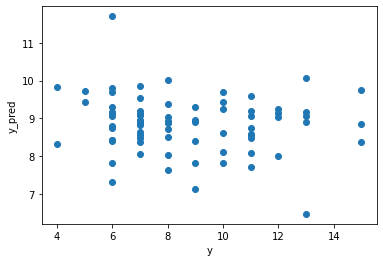

In [23]:

for self_report_regression_var in [
    'bf_1','cancer_promoting_minus_preventing_FFQ',
    'TESQ_E_sum', 'TESQ_E_distraction','TESQ_E_suppression', 
    ]:
    regression_output_folderpath = ml_data_folderpath + "/SST/regress_sr_" + self_report_regression_var
    if os.path.exists(regression_output_folderpath)==False:
        os.mkdir(regression_output_folderpath)
    for source_dataset_name in [
        'correct_stop_w_supplementary','correct_go_w_supplementary','correct_cond_spatially_concatenated']:
        source_output_folderpath = regression_output_folderpath + "/" + source_dataset_name
        if os.path.exists(source_output_folderpath)==False:
            os.mkdir(source_output_folderpath)
#         for mlr_i, mlr in mask_list.iterrows():
#             print(mlr['filename'])
        results_filepath=(
            source_output_folderpath + 
            "/regress_sr_no_zscore" + self_report_regression_var + "_84subs_" + 
        "wholebrain" + ".pkl"
        )
        print(results_filepath)
        do_complete_sr_regression_analysis_for_mask(
            self_report_regression_var = self_report_regression_var,
#             mask_filepath = mlr['filepath'],
#             mask_threshold = mlr['threshold'],
            results_filepath = results_filepath,
            source_dataset_relpath = '/SST/Brain_Data_conditions_84subs_' + source_dataset_name + '.pkl'
        )


In [19]:

for self_report_regression_var in ['TESQ_E_sum', 'TESQ_E_distraction','TESQ_E_suppression']:
    regression_output_folderpath = ml_data_folderpath + "/SST/regress_sr_" + self_report_regression_var
    if os.path.exists(regression_output_folderpath)==False:
        os.mkdir(regression_output_folderpath)
    for source_dataset_name in [
        'correct_stop_w_supplementary','correct_go_w_supplementary','correct_cond_spatially_concatenated']:
        source_output_folderpath = regression_output_folderpath + "/" + source_dataset_name
        if os.path.exists(source_output_folderpath)==False:
            os.mkdir(source_output_folderpath)
        for mlr_i, mlr in mask_list.iterrows():
            print(mlr['filename'])
            results_filepath=(
                source_output_folderpath + 
                "/regress_sr_no_zscore_" + self_report_regression_var + "_84subs_" + 
                mlr['name'] + ".pkl"
            )
            print(results_filepath)
            do_complete_sr_regression_analysis_for_mask(
                self_report_regression_var = self_report_regression_var,
                mask_filepath = mlr['filepath'],
                mask_threshold = mlr['threshold'],
                results_filepath = results_filepath,
                source_dataset_relpath = '/SST/Brain_Data_conditions_84subs_' + source_dataset_name + '.pkl'
            )
            

harvardoxford-cortical_prob_Frontal Orbital Cortex.nii.gz
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/correct_stop_w_supplementary/regress_sr_no_zscore_TESQ_E_sum_84subs_harvardoxford-cortical_prob_Frontal Orbital Cortex.pkl


## harvardoxford-cortical_prob_Frontal Orbital Cortex

checked for intersection and no intersection between the brain data and the subjects was found.
there were 55 subjects overlapping between the subjects marked for train data and the training dump file itself.


NameError: name 'col' is not defined

Should we follow this up with other elemetns of TESQ-E? It's odd that the sum correlates but distraction and suppression do not.

If it's "planning" or something else--I've seen the pattern before. It is possible that with this set of 84, it just so happens that there's a chance correlation between TESQ-E-planning and the item, and it shows up again and again because we're testing pretty much the same thing in different ways.

Also why is the correlation _negative_? LOL. Fuck.

In [37]:
def visualize_series_corr(series1,series2):
    display(HTML(series1.name + " vs " + series2.name))
    pearson_result = pearsonr(series1,series2)
    display(HTML("r=" + format(pearson_result[0],".2f") +"; p-value=" + format(pearson_result[1],".4f")))
    spearman_result = spearmanr(series1,series2)
    display(HTML("rho=" + format(spearman_result[0],".2f") +"; p-value=" + format(spearman_result[1],".4f")))
    cplot = pyplot.scatter(series1,series2)
    cplot.axes.set_xlabel(series1.name)
    cplot.axes.set_ylabel(series2.name)
    pyplot.show()

In [38]:
from matplotlib import pyplot as plt

## generate commands to run the batch version of the above

In [21]:


for self_report_regression_var in ['TESQ_E_sum', 'TESQ_E_distraction','TESQ_E_suppression']:
    regression_output_folderpath = ml_data_folderpath + "/SST/regress_sr_" + self_report_regression_var
    if os.path.exists(regression_output_folderpath)==False:
        os.mkdir(regression_output_folderpath)
    for source_dataset_name in ['correct_go','correct_stop','correct_cond_spatially_concatenated']:
        source_output_folderpath = regression_output_folderpath + "/" + source_dataset_name
        if os.path.exists(source_output_folderpath)==False:
            os.mkdir(source_output_folderpath)
        for mlr_i, mlr in mask_list.iterrows():
            #print(mlr['filename'])
            results_filepath=(
                source_output_folderpath + 
                "/regress_sr_no_zscore_" + self_report_regression_var + "_84subs_" + 
                mlr['name'] + ".pkl"
            )
            print("sbatch run_sr_learning_script.sbatch ml-ns_on_self_report_batch.py" + 
                  " -m \"" + mlr['filepath'] + "\"" + 
                  " -t " + str(mlr['threshold']) + 
                  " -r " + self_report_regression_var + 
                  " -s " + '/SST/Brain_Data_conditions_84subs_' + source_dataset_name + '_w_supplementary.pkl' +
                  " -o \"" + results_filepath + "\"")
        
#             do_complete_sr_regression_analysis_for_mask(
#                 self_report_regression_var = self_report_regression_var,
#                 mask_filepath = mlr['filepath'],
#                 mask_threshold = mlr['threshold'],
#                 results_filepath = results_filepath,
#                 source_dataset_relpath = '/SST/Brain_Data_conditions_84subs_' + source_dataset_name + '_w_supplementary.pkl'
#             )
         

sbatch run_sr_learning_script.sbatch ml-ns_on_self_report_batch.py -m "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/masks/response_inhibition_related/harvardoxford/harvardoxford-cortical_prob_Superior Frontal Gyrus.nii.gz" -t 30 -r TESQ_E_sum -s /SST/Brain_Data_conditions_84subs_correct_go_w_supplementary.pkl -o "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/correct_go/regress_sr_no_zscore_TESQ_E_sum_84subs_harvardoxford-cortical_prob_Superior Frontal Gyrus.pkl"
sbatch run_sr_learning_script.sbatch ml-ns_on_self_report_batch.py -m "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/masks/response_inhibition_related/harvardoxford/harvardoxford-cortical_prob_Frontal Pole.nii.gz" -t 30 -r TESQ_E_sum -s /SST/Brain_Data_conditions_84subs_correct_go_w_supplementary.pkl -o "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/regress_sr_TESQ_E_sum/correct_go/regress_sr_no_zscore_TESQ_E_sum_84subs_harvardoxford-cortical_prob_Frontal Pole.pkl"


## Using the concatenated image version

So I wrote some code to concatenate two different images. This will allow us to train a learner that reads off both CorrectGo and CorrectStop, _separately_, and then pick the best voxels across the group for prediction.

Let's create new input files at the previous step, at `load_multisubject_brain_data_ssw_w1-conditions.ipynb`. Then we can just input the revised data and run it as its own file.